### 필요 라이브러리 불러오기

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import copy

font_path = "C:/Windows/Fonts/MALGUN.TTF"
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
plt.rc('xtick', labelsize=10)
mpl.rcParams['axes.unicode_minus'] = False

### 데이터 파일 불러오기

In [75]:
train = pd.read_csv("../dacon parking demand dataset/train.csv")
test = pd.read_csv("../dacon parking demand dataset/test.csv")
sub = pd.read_csv("../dacon parking demand dataset/test.csv")
age = pd.read_csv("../dacon parking demand dataset/age_gender_info.csv")
rent_deposit = pd.read_csv("../dacon parking demand dataset/predicted_rent_deposit.csv")

In [76]:
train.shape, test.shape, rent_deposit.shape

((2952, 15), (1022, 14), (767, 2))

### 데이터 전처리

In [77]:
# 오류1번 트레인 셋 처리
# 총세대수와 전용면적별 세대수 합이 다른 단지코드의 값을 -> 전용면적별세대수의 합으로 수정하기

def house_number_correction(df):
    error_1_group = df.groupby("단지코드")[["총세대수"]]
    total_number_house_hold = error_1_group.mean()

    error_2_group = df.groupby("단지코드")["전용면적별세대수"]
    sum_house_hold = error_2_group.sum()

    check_df = pd.concat([total_number_house_hold, sum_house_hold], axis=1)
    different_df = check_df[check_df["총세대수"] != check_df["전용면적별세대수"]]

    total_house_index = different_df.index
    total_house_number = []
    for v in different_df.values:
        total_house_number.append(v[1])
    
    for code, value in zip(total_house_index, total_house_number):
         df.loc[df["단지코드"] == code, "총세대수"] = value
    
    return df

train = house_number_correction(train)
test = house_number_correction(test)

In [78]:
error_1_group = train.groupby("단지코드")[["총세대수"]]
total_number_house_hold = error_1_group.mean()

error_2_group = train.groupby("단지코드")["전용면적별세대수"]
sum_house_hold = error_2_group.sum()

check_df = pd.concat([total_number_house_hold, sum_house_hold], axis=1)
check_df = check_df[check_df["총세대수"] != check_df["전용면적별세대수"]]

print(check_df.shape)
check_df

(0, 2)


,총세대수,전용면적별세대수
단지코드,,


In [79]:
error_1_group = test.groupby("단지코드")[["총세대수"]]
total_number_house_hold = error_1_group.mean()

error_2_group = test.groupby("단지코드")["전용면적별세대수"]
sum_house_hold = error_2_group.sum()

check_df = pd.concat([total_number_house_hold, sum_house_hold], axis=1)
check_df = check_df[check_df["총세대수"] != check_df["전용면적별세대수"]]

check_df.shape

(0, 2)

In [80]:
# 오류2번 3번 처리하기

train[(train["단지코드"] == "C2675") | (train["단지코드"] == "C2335") | (train["단지코드"] == "C1327")]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수


In [81]:
test[(test["단지코드"] == "C2675") | (test["단지코드"] == "C2335") | (test["단지코드"] == "C1327")].head(3)

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수
579,C2675,512,아파트,경기도,국민임대,36.65,130,9.0,A,18476000,154790,0.0,3.0,1016.0
580,C2675,512,아파트,경기도,국민임대,46.90,44,9.0,A,34082000,232200,0.0,3.0,1016.0
581,C2675,512,아파트,경기도,국민임대,46.90,80,9.0,A,34082000,232200,0.0,3.0,1016.0


In [82]:
# 테스트 데이터 셋에서 세개의 코드 데이터를 없애기 (2, 3번 3개 코드 제거)

error_index = test[(test["단지코드"] == "C2675") | (test["단지코드"] == "C2335") | (test["단지코드"] == "C1327")].index
test = test.drop(index=error_index, axis=0)

In [83]:
# 에러2번의 5개 단지코드 트레인 셋 제거

train_set_error_index = train[(train["단지코드"] =="C2085") | (train["단지코드"] =="C1397") | (train["단지코드"] =="C2431") | (train["단지코드"] =="C1649") | (train["단지코드"] =="C1036")].index
train = train.drop(index=train_set_error_index, axis=0)

In [84]:
# 에러3번의 트레인 셋 7개 단지 코드 제거

train_set_error_index = train[(train["단지코드"] =="C1095") | (train["단지코드"] =="C2051") | (train["단지코드"] =="C1218") | (train["단지코드"] =="C1894") | (train["단지코드"] =="C2483") | (train["단지코드"] =="C1502") | (train["단지코드"] =="C1988")].index
train = train.drop(index=train_set_error_index, axis=0)

In [85]:
# 자격 유형 피처 전처리

test.loc[196, "자격유형"] = "A"
test.loc[258, "자격유형"] = "C"
test.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           180
임대료                             180
도보 10분거리 내 지하철역 수(환승노선 수 반영)     38
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
dtype: int64

In [86]:
train.isnull().sum()

단지코드                              0
총세대수                              0
임대건물구분                            0
지역                                0
공급유형                              0
전용면적                              0
전용면적별세대수                          0
공가수                               0
자격유형                              0
임대보증금                           569
임대료                             569
도보 10분거리 내 지하철역 수(환승노선 수 반영)    207
도보 10분거리 내 버스정류장 수                0
단지내주차면수                           0
등록차량수                             0
dtype: int64

In [87]:
# 임대보증금 피처 전처리
# 임대보증금이 0인 행의 데이터를 -> 트레인 셋의 지역별 평균 값으로 치환
train_df = train.copy(deep=True)
test_df = test.copy(deep=True)

train_df["임대보증금"] = train_df["임대보증금"].fillna(0)
train_df.loc[train_df["임대보증금"] == "-", "임대보증금"] = 0
train_df["임대보증금"] = train_df["임대보증금"].astype(int)

test_df["임대보증금"] = test_df["임대보증금"].fillna(0)
test_df.loc[test_df["임대보증금"] == "-", "임대보증금"] = 0
test_df["임대보증금"] = test_df["임대보증금"].astype(int)

In [88]:
train_df[train_df["임대보증금"] == 0].index

Int64Index([  88,   89,   90,   91,  101,  102,  103,  104,  105,  106,
            ...
            2549, 2550, 2551, 2680, 2681, 2682, 2683, 2906, 2907, 2908],
           dtype='int64', length=581)

In [89]:
test_df[test_df["임대보증금"] == 0].index

Int64Index([  76,   77,   79,   80,   81,   82,   83,   84,   85,   86,
            ...
             329,  330,  331,  332, 1005, 1006, 1014, 1015, 1016, 1017],
           dtype='int64', length=186)

In [90]:
rent_deposit.iloc[581]

index          76.0
임대보증금    11258525.0
Name: 581, dtype: float64

In [91]:
train_rent_deposit = rent_deposit.iloc[:581]
test_rent_deposit = rent_deposit.iloc[581:]

In [92]:
train_rent_deposit = train_rent_deposit.set_index("index")
test_rent_deposit = test_rent_deposit.set_index("index")

In [93]:
train_df.loc[train_rent_deposit.index, "임대보증금"] = train_rent_deposit["임대보증금"]
test_df.loc[test_rent_deposit.index, "임대보증금"] = test_rent_deposit["임대보증금"]

In [94]:
train_df[train_df["임대보증금"] == 0]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수,등록차량수


In [95]:
test_df[test_df["임대보증금"] == 0]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,단지내주차면수


In [96]:
train_df["임대보증금"].isnull().sum()

0

In [97]:
test_df["임대보증금"].isnull().sum()

0

In [98]:
# 레이블 인코딩인데, 원핫 인코딩으로 바꿔보기

qualification_type_feature = pd.get_dummies(train_df["자격유형"])
train_df = pd.concat([train_df, qualification_type_feature], axis=1)

qualification_type_feature = pd.get_dummies(test_df["자격유형"])
test_df = pd.concat([test_df, qualification_type_feature], axis=1)

test_df["B"] = 0
test_df["F"] = 0
test_df["O"] = 0

In [99]:
train_df.shape, test_df.shape

((2869, 30), (1008, 29))

In [100]:
# 실거주 세대수 피처 생성

train_df["실거주세대수"] = train_df["총세대수"] - train_df["공가수"].astype(int)
test_df["실거주세대수"] = test_df["총세대수"] - test_df["공가수"].astype(int)

In [101]:
# 세대수 별 주차면수 피처 생성

train_df["세대수비율주차면수"] = (train_df["전용면적별세대수"] / train_df["실거주세대수"]) * train_df["단지내주차면수"]
test_df["세대수비율주차면수"] = (test_df["전용면적별세대수"] / test_df["실거주세대수"]) * test_df["단지내주차면수"]

In [102]:
# 버스정류장 피처 전처리
# 최빈값인 2로 채우기

train_df["도보 10분거리 내 버스정류장 수"] = train_df["도보 10분거리 내 버스정류장 수"].fillna(2)
test_df["도보 10분거리 내 버스정류장 수"] = test_df["도보 10분거리 내 버스정류장 수"].fillna(2)

In [103]:
# 전철역 피처 전처리
# Null 값 0으로 채우기

train_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"] = train_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"].fillna(0)
test_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"] = test_df["도보 10분거리 내 지하철역 수(환승노선 수 반영)"].fillna(0)

In [104]:
# 지역 피처 원핫 인코딩

area_df = pd.get_dummies(train_df["지역"])
area_df = area_df.drop("서울특별시", axis=1)
train_df = pd.concat([train_df, area_df], axis=1)

area_df = pd.get_dummies(test_df["지역"])
test_df = pd.concat([test_df, area_df], axis=1)

In [105]:
train_df[train_df["단지코드"] == "C1039"]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,대구광역시,대전광역시,부산광역시,세종특별자치시,울산광역시,전라남도,전라북도,제주특별자치도,충청남도,충청북도
2100,C1039,790,아파트,서울특별시,장기전세,51.32,126,13.0,A,187694000.0,...,0,0,0,0,0,0,0,0,0,0
2101,C1039,790,아파트,서울특별시,장기전세,59.88,49,13.0,A,213863000.0,...,0,0,0,0,0,0,0,0,0,0
2102,C1039,790,아파트,서울특별시,장기전세,59.94,75,13.0,A,213863000.0,...,0,0,0,0,0,0,0,0,0,0
2103,C1039,790,아파트,서울특별시,국민임대,26.68,26,13.0,A,15282000.0,...,0,0,0,0,0,0,0,0,0,0
2104,C1039,790,아파트,서울특별시,국민임대,36.70,140,13.0,A,21024000.0,...,0,0,0,0,0,0,0,0,0,0
2105,C1039,790,아파트,서울특별시,국민임대,36.70,14,13.0,A,21024000.0,...,0,0,0,0,0,0,0,0,0,0
2106,C1039,790,아파트,서울특별시,국민임대,36.87,43,13.0,A,21024000.0,...,0,0,0,0,0,0,0,0,0,0
2107,C1039,790,아파트,서울특별시,국민임대,46.76,192,13.0,A,45456000.0,...,0,0,0,0,0,0,0,0,0,0
2108,C1039,790,아파트,서울특별시,국민임대,46.96,25,13.0,A,45456000.0,...,0,0,0,0,0,0,0,0,0,0
2109,C1039,790,아파트,서울특별시,영구임대,26.68,70,13.0,I,11490000.0,...,0,0,0,0,0,0,0,0,0,0


In [106]:
# 임대건물 구분 피처 전처리 (아파트, 상가 원핫 인코딩)

train_df = pd.concat([train_df, pd.get_dummies(train_df["임대건물구분"])], axis=1)
train_df.drop("임대건물구분", axis=1, inplace=True)

test_df = pd.concat([test_df, pd.get_dummies(test_df["임대건물구분"])], axis=1)
test_df.drop("임대건물구분", axis=1, inplace=True)

In [107]:
# 전용 면적 피처를 5의 배수로 전처리, 전후로 비교해서 (103.69 -> 102.80까지 떨어짐)
train_df["전용면적"] = train_df["전용면적"] // 5*5
test_df["전용면적"] = test_df["전용면적"] // 5*5

In [108]:
# 세대수 규모 당 총 전용 면적 피처 생성

train_df["세대수 규모 당 총 전용면적"] = train_df["전용면적"] * train_df["전용면적별세대수"]
test_df["세대수 규모 당 총 전용면적"] = test_df["전용면적"] * test_df["전용면적별세대수"]

In [109]:
# 단지별 총 전용 면적 피처 생성

train_df["단지별 총 전용면적"] = train_df.groupby("단지코드")["세대수 규모 당 총 전용면적"].transform(np.sum)
test_df["단지별 총 전용면적"] = test_df.groupby("단지코드")["세대수 규모 당 총 전용면적"].transform(np.sum)

In [110]:
# 전용면적 당 차량등록수 피처 생성

train_df["전용면적 당 차량등록수"] = (train_df["세대수 규모 당 총 전용면적"] / train_df["단지별 총 전용면적"]) * train_df["등록차량수"]

In [111]:
train_df["공급유형"].value_counts()

국민임대         1727
임대상가          562
행복주택          202
공공임대(10년)     175
영구임대          152
공공임대(50년)      31
공공분양            7
공공임대(분납)        7
장기전세            3
공공임대(5년)        3
Name: 공급유형, dtype: int64

In [112]:
train_df[train_df["공급유형"] == "장기전세"]

,단지코드,총세대수,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,...,전라남도,전라북도,제주특별자치도,충청남도,충청북도,상가,아파트,세대수 규모 당 총 전용면적,단지별 총 전용면적,전용면적 당 차량등록수
2100,C1039,790,서울특별시,장기전세,50.0,126,13.0,A,187694000.0,-,...,0,0,0,0,0,0,1,6300.0,33080.0,122.838573
2101,C1039,790,서울특별시,장기전세,55.0,49,13.0,A,213863000.0,-,...,0,0,0,0,0,0,1,2695.0,33080.0,52.547612
2102,C1039,790,서울특별시,장기전세,55.0,75,13.0,A,213863000.0,-,...,0,0,0,0,0,0,1,4125.0,33080.0,80.430018


In [113]:
test_df["공급유형"].value_counts() # 테스트 셋에는 없는 공급유형 -> 공공분양, 공공임대(5년), 장기전세

국민임대         614
임대상가         177
행복주택         120
영구임대          43
공공임대(10년)     35
공공임대(50년)     13
공공임대(분납)       6
Name: 공급유형, dtype: int64

In [114]:
supply_qualification_df = pd.get_dummies(train_df["공급유형"])
train_df = pd.concat([train_df, supply_qualification_df], axis=1)

supply_qualification_df = pd.get_dummies(test_df["공급유형"])
test_df = pd.concat([test_df, supply_qualification_df], axis=1)
test_df["공공임대(5년)"] = 0
test_df["공공분양"] = 0
test_df["장기전세"] = 0

In [115]:
train_df.columns

Index(['단지코드', '총세대수', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
       '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수',
       '단지내주차면수', '등록차량수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '실거주세대수', '세대수비율주차면수', '강원도', '경기도', '경상남도',
       '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도',
       '전라북도', '제주특별자치도', '충청남도', '충청북도', '상가', '아파트', '세대수 규모 당 총 전용면적',
       '단지별 총 전용면적', '전용면적 당 차량등록수', '공공분양', '공공임대(10년)', '공공임대(50년)',
       '공공임대(5년)', '공공임대(분납)', '국민임대', '영구임대', '임대상가', '장기전세', '행복주택'],
      dtype='object')

In [116]:
test_df.columns

Index(['단지코드', '총세대수', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
       '임대보증금', '임대료', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수',
       '단지내주차면수', 'A', 'C', 'D', 'E', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
       'B', 'F', 'O', '실거주세대수', '세대수비율주차면수', '강원도', '경기도', '경상남도', '경상북도',
       '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도',
       '제주특별자치도', '충청남도', '충청북도', '상가', '아파트', '세대수 규모 당 총 전용면적', '단지별 총 전용면적',
       '공공임대(10년)', '공공임대(50년)', '공공임대(분납)', '국민임대', '영구임대', '임대상가', '행복주택',
       '공공임대(5년)', '공공분양', '장기전세'],
      dtype='object')

In [117]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2869 entries, 8 to 2951
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   단지코드                          2869 non-null   object 
 1   총세대수                          2869 non-null   int64  
 2   지역                            2869 non-null   object 
 3   공급유형                          2869 non-null   object 
 4   전용면적                          2869 non-null   float64
 5   전용면적별세대수                      2869 non-null   int64  
 6   공가수                           2869 non-null   float64
 7   자격유형                          2869 non-null   object 
 8   임대보증금                         2869 non-null   float64
 9   임대료                           2300 non-null   object 
 10  도보 10분거리 내 지하철역 수(환승노선 수 반영)  2869 non-null   float64
 11  도보 10분거리 내 버스정류장 수            2869 non-null   float64
 12  단지내주차면수                       2869 non-null   float64
 13  등록차

In [118]:
# 503, 1871, 1951, 1977, 2023

outlier_index = train_df[train_df["전용면적별세대수"] >= 1000].index
train_df = train_df.drop(index=outlier_index, axis=0)

In [119]:
outlier_index = train_df[(train_df["전용면적별세대수"] <= 30) & (train_df["전용면적 당 차량등록수"] >=400)].index
train_df = train_df.drop(index=outlier_index, axis=0)

In [120]:
# 301 아웃라이어 제거

train_df[(train_df["전용면적별세대수"] > 150) & (train_df["전용면적 당 차량등록수"] > 750)]

train_df = train_df.drop(index=301, axis=0)

In [121]:
# 1974, 2141, 2532

outlier_index = train_df[train_df["세대수 규모 당 총 전용면적"] > 40000].index

train_df = train_df.drop(index=outlier_index, axis=0)

In [122]:
# 임대보증금 아웃라이어 2111, 2812, 2813, 2814 제거

outlier_index = train_df[train_df["임대보증금"] >= 187694000].index
train_df = train_df.drop(index=outlier_index, axis=0)

In [123]:
# 세대수비율주차면수 아웃라이어 제거 314

outlier_index = train_df[(train_df["세대수비율주차면수"] >= 700) & (train_df["전용면적 당 차량등록수"] < 400)].index
train_df = train_df.drop(index=outlier_index, axis=0)

In [124]:
# X_train & X_test 셋 선택

# ["상가", "등록차량수", "단지내주차면수", "단지별 총 전용면적", "실거주세대수", "지역", "공급유형", "전용면적", "자격유형", "임대료",
#  "전용면적 당 차량등록수", "총세대수"]

X_train_df_sel = train_df.drop(["단지코드", "상가", "등록차량수", "단지내주차면수", "단지별 총 전용면적", "실거주세대수", "지역", "공급유형", "전용면적", "자격유형", "임대료",
 "전용면적 당 차량등록수", "총세대수"], axis=1)

X_test_df_sel = test_df.drop(["단지코드", "상가", "단지내주차면수", "단지별 총 전용면적", "실거주세대수", "지역", "공급유형", "전용면적", "자격유형", "임대료",
 "총세대수"], axis=1)

y_train_df = train_df["전용면적 당 차량등록수"]

In [125]:
X_train_df_sel.columns

Index(['전용면적별세대수', '공가수', '임대보증금', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '세대수비율주차면수', '강원도', '경기도', '경상남도', '경상북도',
       '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도',
       '제주특별자치도', '충청남도', '충청북도', '아파트', '세대수 규모 당 총 전용면적', '공공분양',
       '공공임대(10년)', '공공임대(50년)', '공공임대(5년)', '공공임대(분납)', '국민임대', '영구임대',
       '임대상가', '장기전세', '행복주택'],
      dtype='object')

In [126]:
column_names = ['전용면적별세대수', '공가수', '임대보증금', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '세대수비율주차면수', '강원도', '경기도', '경상남도', '경상북도',
       '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도',
       '제주특별자치도', '충청남도', '충청북도', '아파트', '세대수 규모 당 총 전용면적', '공공분양',
       '공공임대(10년)', '공공임대(50년)', '공공임대(5년)', '공공임대(분납)', '국민임대', '영구임대',
       '임대상가', '장기전세', '행복주택']

X_test_df_sel = X_test_df_sel.reindex(columns=column_names)
X_test_df_sel.columns

Index(['전용면적별세대수', '공가수', '임대보증금', '도보 10분거리 내 지하철역 수(환승노선 수 반영)',
       '도보 10분거리 내 버스정류장 수', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
       'K', 'L', 'M', 'N', 'O', '세대수비율주차면수', '강원도', '경기도', '경상남도', '경상북도',
       '광주광역시', '대구광역시', '대전광역시', '부산광역시', '세종특별자치시', '울산광역시', '전라남도', '전라북도',
       '제주특별자치도', '충청남도', '충청북도', '아파트', '세대수 규모 당 총 전용면적', '공공분양',
       '공공임대(10년)', '공공임대(50년)', '공공임대(5년)', '공공임대(분납)', '국민임대', '영구임대',
       '임대상가', '장기전세', '행복주택'],
      dtype='object')

In [127]:
X_train_df_sel

,전용면적별세대수,공가수,임대보증금,도보 10분거리 내 지하철역 수(환승노선 수 반영),도보 10분거리 내 버스정류장 수,A,B,C,D,E,...,공공분양,공공임대(10년),공공임대(50년),공공임대(5년),공공임대(분납),국민임대,영구임대,임대상가,장기전세,행복주택
8,276,17.0,9216000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
9,60,17.0,12672000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
10,20,17.0,12672000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
11,38,17.0,18433000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
12,19,17.0,18433000.0,0.0,3.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,19,7.0,11346000.0,0.0,1.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2948,34,7.0,14005000.0,0.0,1.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2949,34,7.0,14005000.0,0.0,1.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2950,114,7.0,14005000.0,0.0,1.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [128]:
X_train_df_log = X_train_df_sel.apply(lambda x: np.log1p(x))
X_test_df_log = X_test_df_sel.apply(lambda x: np.log1p(x))
y_train_df_log = y_train_df.apply(lambda x: np.log1p(x))

### Linear Regression 모델 평가

In [129]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from catboost import Pool, CatBoostRegressor

In [130]:
X_train_df_log.shape, X_test_df_log.shape, y_train_df_log.shape

((2854, 48), (1008, 48), (2854,))

In [131]:
params = {"alpha": [0.001, 0.01, 0.02, 0.03, 0.05, 0.07, 0.9, 1, 1.1, 1.5, 2, 5, 10, 15, 20, 25, 30, 40, 50]}
ridge_model = Ridge()

grid_model = GridSearchCV(ridge_model, param_grid=params, cv=5, scoring="neg_mean_absolute_error")
grid_model.fit(X_train_df_log, y_train_df_log)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.02, 0.03, 0.05, 0.07, 0.9, 1,
                                   1.1, 1.5, 2, 5, 10, 15, 20, 25, 30, 40,
                                   50]},
             scoring='neg_mean_absolute_error')

In [132]:
grid_model.best_params_

{'alpha': 30}

In [133]:
best_ridge = grid_model.best_estimator_
best_ridge

Ridge(alpha=30)

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25,
                                                    random_state=42)

pred = best_ridge.predict(X_test)
mean_absolute_error(np.expm1(y_test), np.expm1(pred))

14.716942200737751

In [135]:
ridge_model = Ridge(alpha=30)
ridge_model.fit(X_train_df_log, y_train_df_log)
pred = ridge_model.predict(X_test_df_log)
pred = np.expm1(pred)

result = pd.DataFrame(data=pred, columns=["전용면적 당 차량등록수"], index=test_df.index)
result["단지코드"] = test_df.loc[test_df.index, "단지코드"]

pred_group = result.groupby("단지코드")["전용면적 당 차량등록수"].sum()
final_pred = pd.Series(pred_group)
final_pred = final_pred.reset_index(drop=False)

sub_df = sub.merge(final_pred, how="left")
sub_df = sub_df.drop_duplicates(["단지코드"], keep="first").reset_index()
sub_df = sub_df[["단지코드", "전용면적 당 차량등록수"]]
sub_df = sub_df.rename(columns={"단지코드":"code", "전용면적 당 차량등록수": "num"})
# sub_df.to_csv("ridge_with_이상치처리_다중공선성피처제거_0722.csv", index=False)

sub_df.shape

(150, 2)

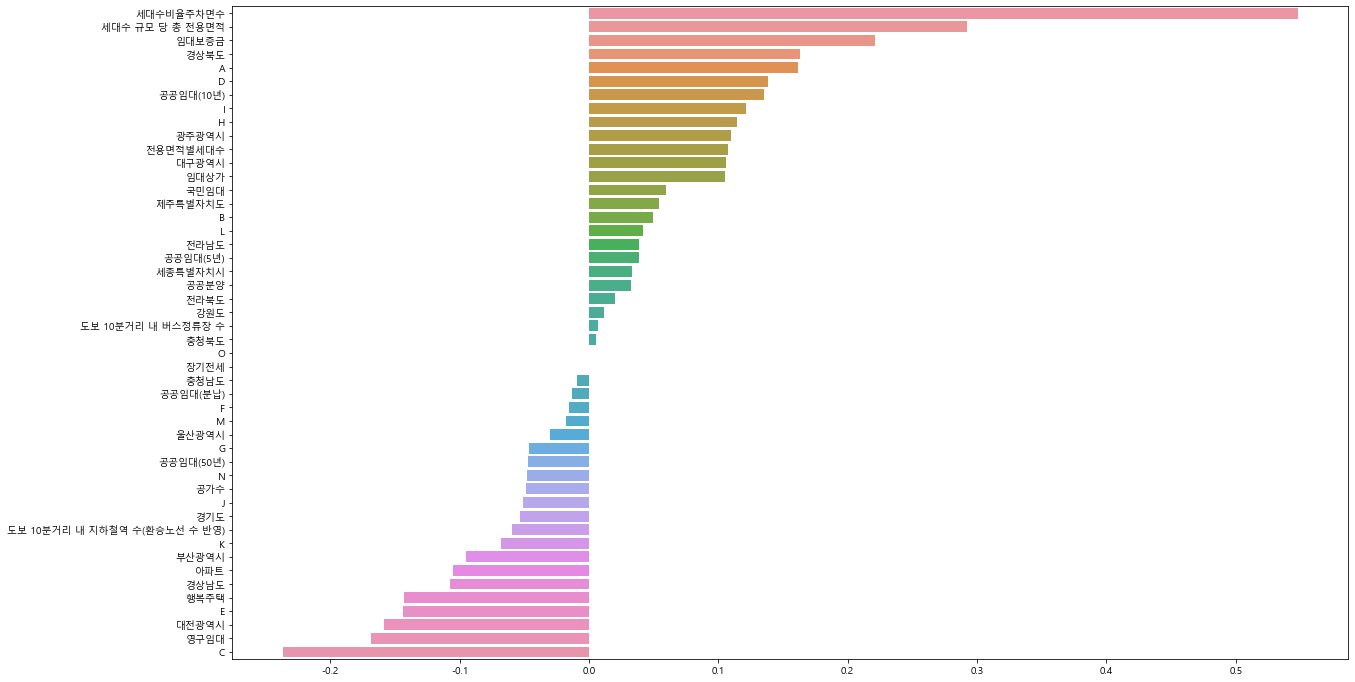

In [136]:
importance = ridge_model.coef_
feature_importance = pd.Series(data=importance, index=X_train_df_log.columns)
feature_importance = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(20, 12))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.show()

In [137]:
cat_reg = CatBoostRegressor()

cat_reg.fit(X_train, y_train)
pred = cat_reg.predict(X_test)

mean_absolute_error(np.expm1(y_test), np.expm1(pred))

Learning rate set to 0.04469
0:	learn: 1.7666323	total: 1.89ms	remaining: 1.89s
1:	learn: 1.6949588	total: 3.54ms	remaining: 1.77s
2:	learn: 1.6282127	total: 5ms	remaining: 1.66s
3:	learn: 1.5617337	total: 6.28ms	remaining: 1.56s
4:	learn: 1.5006612	total: 7.1ms	remaining: 1.41s
5:	learn: 1.4393472	total: 8.38ms	remaining: 1.39s
6:	learn: 1.3816965	total: 9.63ms	remaining: 1.36s
7:	learn: 1.3295461	total: 10.9ms	remaining: 1.35s
8:	learn: 1.2757298	total: 12.2ms	remaining: 1.34s
9:	learn: 1.2260460	total: 13.4ms	remaining: 1.33s
10:	learn: 1.1799607	total: 14.6ms	remaining: 1.31s
11:	learn: 1.1340970	total: 15.8ms	remaining: 1.3s
12:	learn: 1.0905202	total: 17ms	remaining: 1.29s
13:	learn: 1.0480217	total: 18.2ms	remaining: 1.28s
14:	learn: 1.0092599	total: 18.9ms	remaining: 1.24s
15:	learn: 0.9705941	total: 20.1ms	remaining: 1.24s
16:	learn: 0.9348442	total: 21.1ms	remaining: 1.22s
17:	learn: 0.8998656	total: 22.3ms	remaining: 1.22s
18:	learn: 0.8689824	total: 23.7ms	remaining: 1.22s


253:	learn: 0.1877308	total: 322ms	remaining: 945ms
254:	learn: 0.1874285	total: 323ms	remaining: 944ms
255:	learn: 0.1871159	total: 325ms	remaining: 943ms
256:	learn: 0.1869205	total: 326ms	remaining: 942ms
257:	learn: 0.1868263	total: 327ms	remaining: 941ms
258:	learn: 0.1864514	total: 329ms	remaining: 940ms
259:	learn: 0.1862580	total: 330ms	remaining: 939ms
260:	learn: 0.1861856	total: 331ms	remaining: 937ms
261:	learn: 0.1857212	total: 332ms	remaining: 936ms
262:	learn: 0.1855024	total: 334ms	remaining: 935ms
263:	learn: 0.1853044	total: 335ms	remaining: 934ms
264:	learn: 0.1852142	total: 336ms	remaining: 932ms
265:	learn: 0.1849298	total: 337ms	remaining: 931ms
266:	learn: 0.1847282	total: 339ms	remaining: 930ms
267:	learn: 0.1842709	total: 340ms	remaining: 928ms
268:	learn: 0.1841518	total: 341ms	remaining: 927ms
269:	learn: 0.1840600	total: 342ms	remaining: 926ms
270:	learn: 0.1835032	total: 344ms	remaining: 925ms
271:	learn: 0.1833900	total: 345ms	remaining: 923ms
272:	learn: 

517:	learn: 0.1431663	total: 656ms	remaining: 610ms
518:	learn: 0.1428218	total: 657ms	remaining: 609ms
519:	learn: 0.1427177	total: 659ms	remaining: 608ms
520:	learn: 0.1424385	total: 660ms	remaining: 607ms
521:	learn: 0.1423763	total: 661ms	remaining: 606ms
522:	learn: 0.1421848	total: 663ms	remaining: 604ms
523:	learn: 0.1420132	total: 664ms	remaining: 603ms
524:	learn: 0.1419696	total: 665ms	remaining: 602ms
525:	learn: 0.1417926	total: 666ms	remaining: 600ms
526:	learn: 0.1416942	total: 668ms	remaining: 599ms
527:	learn: 0.1415588	total: 669ms	remaining: 598ms
528:	learn: 0.1414968	total: 670ms	remaining: 597ms
529:	learn: 0.1413085	total: 671ms	remaining: 595ms
530:	learn: 0.1411725	total: 673ms	remaining: 594ms
531:	learn: 0.1409901	total: 674ms	remaining: 593ms
532:	learn: 0.1408716	total: 675ms	remaining: 592ms
533:	learn: 0.1407773	total: 677ms	remaining: 590ms
534:	learn: 0.1406685	total: 678ms	remaining: 589ms
535:	learn: 0.1404631	total: 679ms	remaining: 588ms
536:	learn: 

780:	learn: 0.1140053	total: 990ms	remaining: 278ms
781:	learn: 0.1138808	total: 992ms	remaining: 276ms
782:	learn: 0.1138445	total: 993ms	remaining: 275ms
783:	learn: 0.1137988	total: 994ms	remaining: 274ms
784:	learn: 0.1136589	total: 996ms	remaining: 273ms
785:	learn: 0.1135539	total: 997ms	remaining: 271ms
786:	learn: 0.1134707	total: 998ms	remaining: 270ms
787:	learn: 0.1132238	total: 1000ms	remaining: 269ms
788:	learn: 0.1131580	total: 1s	remaining: 268ms
789:	learn: 0.1130431	total: 1s	remaining: 267ms
790:	learn: 0.1129968	total: 1s	remaining: 265ms
791:	learn: 0.1129552	total: 1s	remaining: 264ms
792:	learn: 0.1128166	total: 1.01s	remaining: 263ms
793:	learn: 0.1127881	total: 1.01s	remaining: 261ms
794:	learn: 0.1127664	total: 1.01s	remaining: 260ms
795:	learn: 0.1126696	total: 1.01s	remaining: 259ms
796:	learn: 0.1125882	total: 1.01s	remaining: 258ms
797:	learn: 0.1125268	total: 1.01s	remaining: 256ms
798:	learn: 0.1124295	total: 1.01s	remaining: 255ms
799:	learn: 0.1122458	t

9.38574738025158

In [138]:
# 릿지 0.5 & LGBM 0.5 조합 -> 12.3456 Score: 93.5424 (인구데이터 추가)
# 릿지 1.0 -> 14.9751 Score: 95.6543 (인구데이터 X)

# 릿지 0.9 & CatBoost 0.1 조합 -> 14.18295
# 릿지 0.8 & CatBoost 0.2 조합 -> 13.4380
# 릿지 0.7 & CatBoost 0.3 조합 -> 12.7728
# 릿지 0.6 & CatBoost 0.4 조합 -> 12.1470
# 릿지 0.5 & CatBoost 0.5 조합 -> 11.6074

# 릿지 alpha=50, 값으로 예측!!! 결과
# 릿지 0.5 & CatBoost 0.5 조합 -> 11.6044
# 릿지 0.4 & CatBoost 0.6 조합 -> 11.0139
# 릿지 0.3 & CatBoost 0.7 조합 -> 10.5106

# 릿지 alpha=40,값으로 예측!! 결과
# 릿지 0.3 & CatBoost 0.7 조합 -> 10.4283
# 릿지 0.4 & CatBoost 0.6 조합 -> 10.9511

ridge_model = Ridge(alpha=30)
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)

cat_reg = CatBoostRegressor(random_seed=42, verbose=False)
cat_reg.fit(X_train, y_train)
cat_pred = cat_reg.predict(X_test)

final_pred = (ridge_pred * 0.4) + (cat_pred * 0.6)
mean_absolute_error(np.expm1(y_test), np.expm1(final_pred))

10.850410755854305

In [139]:
# 릿지 (alpha=40) 0.4 & CatBoost 0.6 조합 -> 88.6317475529 , MAE -> 10.9511
# 릿지 (alpha=40) 0.3 & CatBoost 0.7 조합 -> 89.9021750236, MAE -> 10.4283

ridge_model = Ridge(alpha=30)
ridge_model.fit(X_train_df_log, y_train_df_log)
ridge_pred = ridge_model.predict(X_test_df_log)

cat_reg = CatBoostRegressor(random_seed=42, verbose=False)
cat_reg.fit(X_train_df_log, y_train_df_log)
cat_pred = cat_reg.predict(X_test_df_log)

final_pred = (ridge_pred * 0.4) + (cat_pred * 0.6)
final_pred = np.expm1(final_pred)

result = pd.DataFrame(data=final_pred, columns=["전용면적 당 차량등록수"], index=test_df.index)
result["단지코드"] = test_df.loc[test_df.index, "단지코드"]

pred_group = result.groupby("단지코드")["전용면적 당 차량등록수"].sum()
final_pred = pd.Series(pred_group)
final_pred = final_pred.reset_index(drop=False)

sub_df = sub.merge(final_pred, how="left")
sub_df = sub_df.drop_duplicates(["단지코드"], keep="first").reset_index()
sub_df = sub_df[["단지코드", "전용면적 당 차량등록수"]]
sub_df = sub_df.rename(columns={"단지코드":"code", "전용면적 당 차량등록수": "num"})
# sub_df.to_csv("ridge(0.4)&catboost(0.6)조합_공급유형추가_임대보증금지역예측값적용_0727.csv", index=False)

sub_df.shape

(150, 2)

In [140]:
from sklearn.linear_model import Lasso


params = {"alpha": [0.0005, 0.0009, 0.001, 0.01, 0.02, 0.03, 0.05, 0.07, 0.9, 1, 1.1, 1.5, 2, 5, 10, 15, 20, 25, 30, 40, 50]}
lasso_model = Lasso()


lasso_grid = GridSearchCV(lasso_model, param_grid=params, cv=5, scoring="neg_mean_absolute_error")
lasso_grid.fit(X_train_df_log, y_train_df_log)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0005, 0.0009, 0.001, 0.01, 0.02, 0.03,
                                   0.05, 0.07, 0.9, 1, 1.1, 1.5, 2, 5, 10, 15,
                                   20, 25, 30, 40, 50]},
             scoring='neg_mean_absolute_error')

In [141]:
lasso_grid.best_params_

{'alpha': 0.001}

In [142]:
lasso_grid.best_estimator_.coef_

array([ 0.01841803, -0.04826869,  0.2036506 , -0.04053434,  0.00679913,
        0.05476811,  0.        , -0.44141234,  0.25967366, -0.31411567,
       -0.        , -0.        ,  0.02426457,  0.        , -0.        ,
       -0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.61561323,  0.        , -0.06028042, -0.11501622,  0.18402428,
        0.11944266,  0.08506094, -0.19936287, -0.11070919,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.00686454, -0.        ,
       -0.        , -0.        ,  0.31677327,  0.        ,  0.06655938,
       -0.        ,  0.        , -0.        ,  0.        , -0.11195762,
        0.        ,  0.        , -0.30563598])

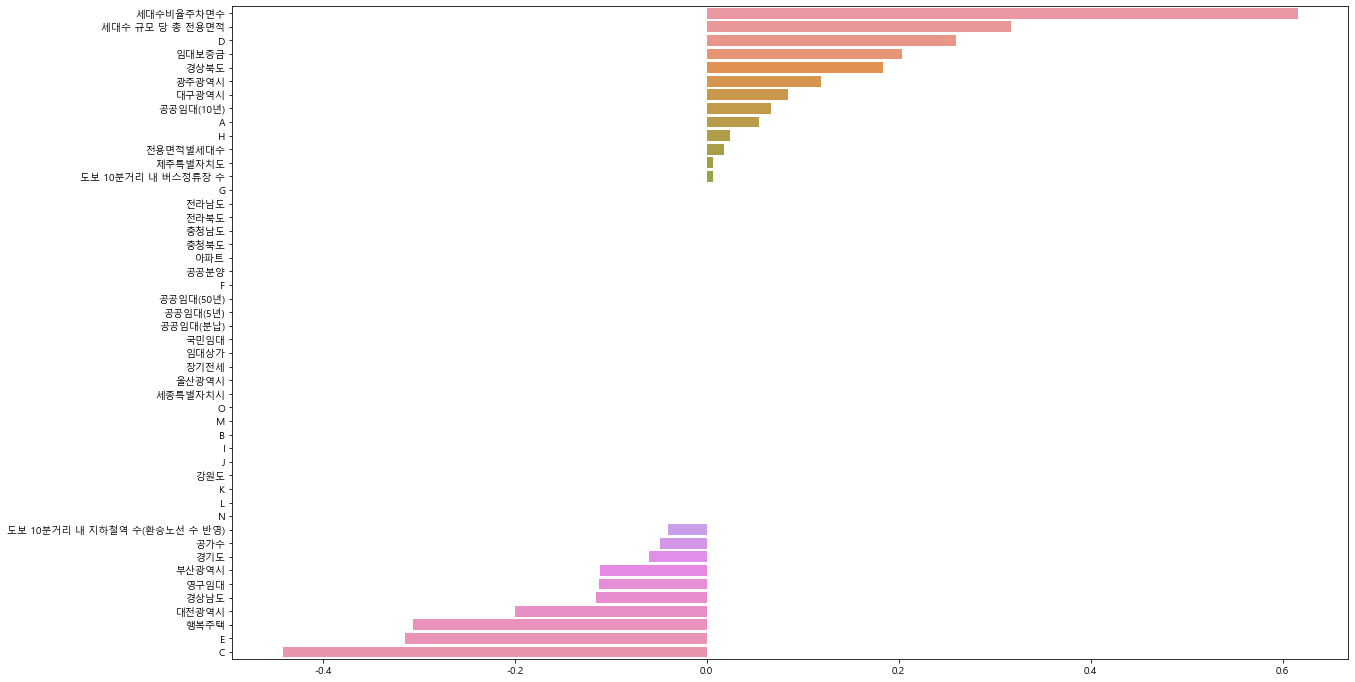

In [143]:
importance = lasso_grid.best_estimator_.coef_
feature_importance = pd.Series(data=importance, index=X_train_df_log.columns)
feature_importance = feature_importance.sort_values(ascending=False)

plt.figure(figsize=(20, 12))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.show()

In [144]:
lasso_best = lasso_grid.best_estimator_


X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25,
                                                    random_state=42)

pred = lasso_best.predict(X_test)
mean_absolute_error(np.expm1(y_test), np.expm1(pred))

14.743851050751408

### Ridge & Lasso & CatBoost 조합 -> 0.2 & 0.2 & 0.6 조합

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X_train_df_log, y_train_df_log, test_size=0.25,
                                                    random_state=42)

ridge_model = Ridge(alpha=30)
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)

lasso_model = Lasso(alpha=0.001)
lasso_model.fit(X_train, y_train)
lasso_pred = lasso_model.predict(X_test)

cat_reg = CatBoostRegressor(random_seed=42, verbose=False)
cat_reg.fit(X_train, y_train)
cat_pred = cat_reg.predict(X_test)

linear_model_pred = (ridge_pred * 0.5) + (lasso_pred * 0.5)
final_pred = (linear_model_pred * 0.4) + (cat_pred * 0.6)

mean_absolute_error(np.expm1(y_test), np.expm1(final_pred))

10.823021623086882

In [146]:
ridge_model = Ridge(alpha=30)
ridge_model.fit(X_train_df_log, y_train_df_log)
ridge_pred = ridge_model.predict(X_test_df_log)

lasso_model = Lasso(alpha=0.001)
lasso_model.fit(X_train_df_log, y_train_df_log)
lasso_pred = lasso_model.predict(X_test_df_log)

cat_reg = CatBoostRegressor(random_seed=42, verbose=False)
cat_reg.fit(X_train_df_log, y_train_df_log)
cat_pred = cat_reg.predict(X_test_df_log)

linear_model_pred = (ridge_pred * 0.5) + (lasso_pred * 0.5)
final_pred = (linear_model_pred * 0.4) + (cat_pred * 0.6)
final_pred = np.expm1(final_pred)

result = pd.DataFrame(data=final_pred, columns=["전용면적 당 차량등록수"], index=test_df.index)
result["단지코드"] = test_df.loc[test_df.index, "단지코드"]

pred_group = result.groupby("단지코드")["전용면적 당 차량등록수"].sum()
final_pred = pd.Series(pred_group)
final_pred = final_pred.reset_index(drop=False)

sub_df = sub.merge(final_pred, how="left")
sub_df = sub_df.drop_duplicates(["단지코드"], keep="first").reset_index()
sub_df = sub_df[["단지코드", "전용면적 당 차량등록수"]]
sub_df = sub_df.rename(columns={"단지코드":"code", "전용면적 당 차량등록수": "num"})
# sub_df.to_csv("ridge(0.2) & lasso(0.2)& catboost(0.6)조합_공급유형추가_임대보증금예측값적용_0728.csv", index=False)

sub_df.shape

(150, 2)